### Packages

In [1]:
#pip install yfinance pycausalimpact prophet

     ---------------------------------------- 12.9/12.9 MB 4.5 MB/s eta 0:00:00
     ---------------------------------------- 47.9/47.9 kB ? eta 0:00:00
     ---------------------------------------- 83.2/83.2 kB 4.6 MB/s eta 0:00:00
     -------------------------------------- 754.3/754.3 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 1.4/1.4 MB 1.3 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732001 sha256=d3b4e94cdfdd66b1c64df96452078533585bac239e1353fbb50a9af5a3c6f397
  Stored in directory: c:\users\rayan\appdata\local\pip\cache\wheels\04\1f\e5\8dd0c661cd8d252817655dc14a84f7ae045d6616594145aa81
Successfully built pymeeus
Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install plotly

     ---------------------------------------- 15.6/15.6 MB 2.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
#pip install tigramite


     -------------------------------------- 250.2/250.2 kB 3.8 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 4.6 MB/s eta 0:00:00
     ---------------------------------------- 23.2/23.2 MB 4.4 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from prophet import Prophet
from causalimpact import CausalImpact
import os
pd.set_option('display.max_columns', None)



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### Segregate data; Pre period is before the scandal and Post period is after

In [2]:
pre_period = [pd.to_datetime('2010-1-1'), pd.to_datetime('2015-9-19')]
post_period = [pd.to_datetime('2015-9-20'), pd.to_datetime('2015-12-31')]

In [3]:
#stocks on nyse for counterfactual
nyse_tickers = pd.read_csv('Stock_Ticker_Symbol.csv')
nyse_tickers.drop('Unnamed: 0', axis=1, inplace=True)
stocks = list(nyse_tickers['stocks'].values)
print(f'Number of ticker symbols in the list: {len(stocks):,.0f}')

Number of ticker symbols in the list: 1,811


#### Import stock data from Yahoo Finance for specified time frame 2010-2015

In [ ]:
stock_data = yf.download(start = pre_period[0], end = post_period[1], tickers=stocks)

# Select just the adjusted close column for each ticker
adj_close = stock_data.loc[:,'Adj Close']

# Format the index as a pandas date object
adj_close.index = pd.to_datetime(adj_close.index)

[******************    38%%                      ]  680 of 1811 completed

### Data Preprocessing 

In [9]:
#removing stocks with >100 missing values
count_na = adj_close.isna().sum().sort_values()
keep_stocks = count_na[count_na < 100]
adj_close = adj_close[keep_stocks.index]

# Print how many stocks are left after removing nans
num_stocks_left = len(adj_close.columns)
print(f'There are {num_stocks_left:,.0f} stocks left after removing nans')

There are 1,343 stocks left after removing nans


In [10]:
#fix missing dates
# Create a dataframe with the complete date range
full_dates = pd.date_range(start = pre_period[0], end = post_period[1])
full_dates = pd.DataFrame(full_dates, columns=['full_dates'])

# Left join the stock data to the dataframe with the complete date range
adj_close = full_dates.merge(adj_close, left_on='full_dates', right_index=True, how='left')

# Put the date in the index
adj_close.set_index('full_dates', inplace=True)

print('Shape of data after fixing missing dates:', adj_close.shape)

Shape of data after fixing missing dates: (2191, 1343)


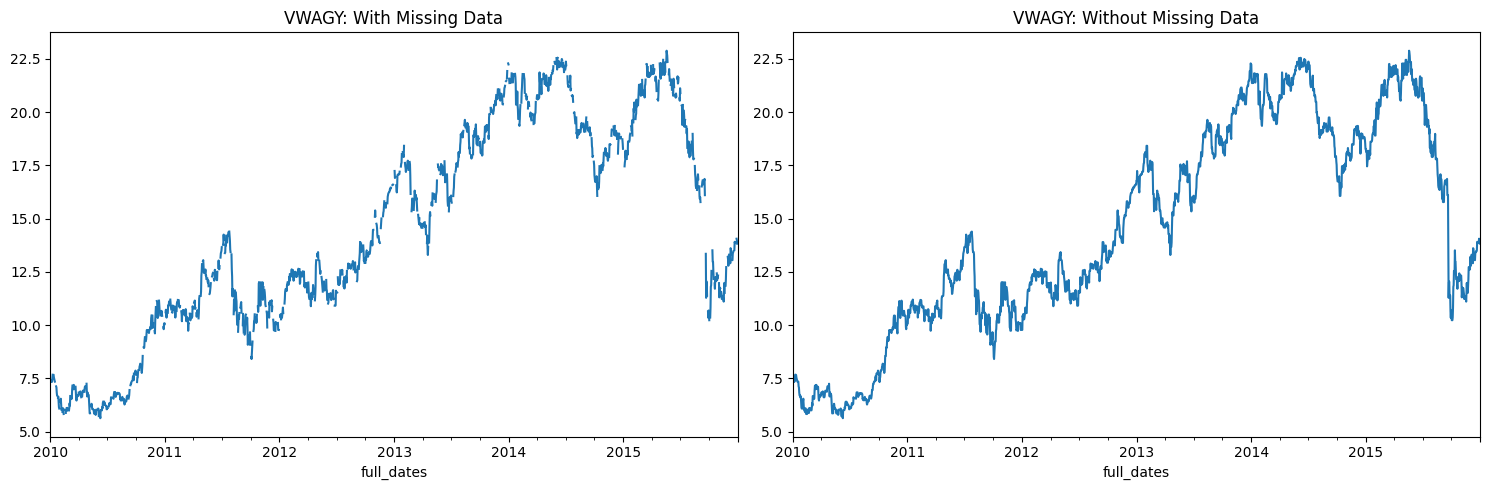

In [11]:
#impute missing data

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
adj_close['VWAGY'].plot()
plt.title('VWAGY: With Missing Data')

plt.subplot(1, 2, 2)
adj_close = adj_close.fillna(method='ffill').fillna(method='bfill')
adj_close['VWAGY'].plot()
plt.title('VWAGY: Without Missing Data')
plt.tight_layout()
plt.show()

#### Split Data Before and After Emissions Announcement

In [12]:
adj_close['emissions_timeframe'] = adj_close.index.map(lambda x: 'pre' if x < post_period[0] else 'post')

# Count the number of days before and after emissions announcement
adj_close.groupby('emissions_timeframe').count().iloc[:,1]

emissions_timeframe
post     103
pre     2088
Name: MYC, dtype: int64

### EDA

In [13]:
adj_close[['VWAGY', 'emissions_timeframe']].groupby('emissions_timeframe').describe().T

emissions_timeframe        post          pre
VWAGY count          103.000000  2088.000000
      mean            12.362696    14.595356
      std              1.070372     5.003499
      min             10.232208     5.630341
      25%             11.514005    10.678863
      50%             12.248047    14.272693
      75%             13.305862    19.093764
      max             16.104532    22.888302

#### 7 Day Rolling Average Marking Day of Scandal

Text(0.5, 1.0, 'VWAGY: 7 Day Rolling Average')

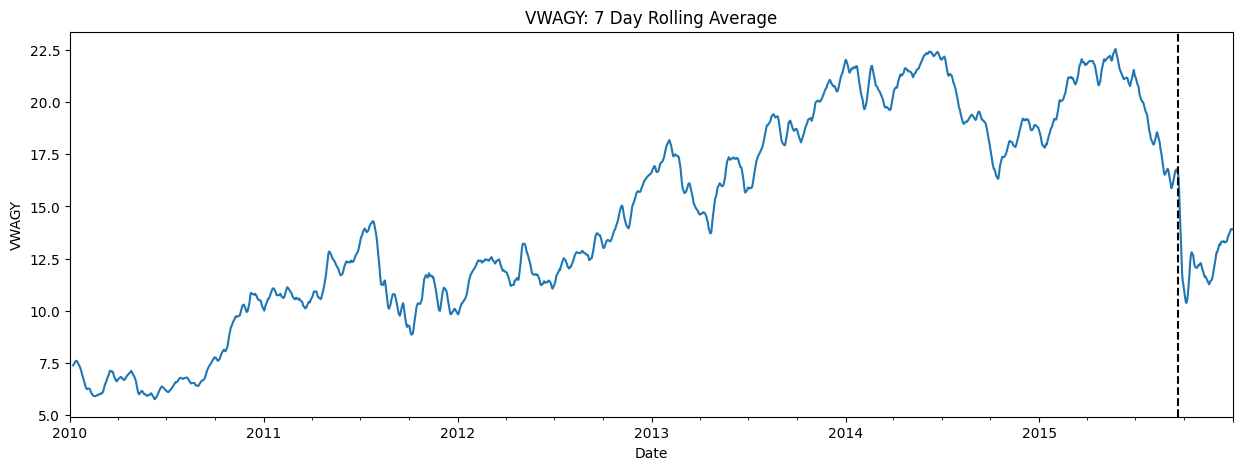

In [14]:
plt.figure(figsize=(15,5))
adj_close['VWAGY'].rolling(7).mean().plot()
plt.axvline(post_period[0], color='black', linestyle='--',)
plt.xlabel('Date')
plt.ylabel('VWAGY')
plt.title('VWAGY: 7 Day Rolling Average')

#### Before and After Scandal Data

In [ ]:
volks_pre = adj_close[adj_close['emissions_timeframe'] == 'pre']['VWAGY']
volks_post = adj_close[adj_close['emissions_timeframe'] == 'post']['VWAGY']

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.histplot(volks_pre)
plt.title('Pre Period')

plt.subplot(1, 2, 2)
sns.histplot(volks_post)
plt.title('Post Period')
plt.tight_layout()
plt.show()

#### Stocks that are related to Volkswagen in the pre period

In [18]:
corr_pre = adj_close[adj_close['emissions_timeframe'] == 'pre'].corr().abs()
corr_pre = corr_pre['VWAGY'].sort_values(ascending=False)
vwagy_corr = list(corr_pre[corr_pre > 0.95].index)
print(f'There are {len(vwagy_corr)} stocks that correlate with VWAGY in the pre period')


# Filter dataset to only include stocks that correlate with Volkswagen in the pre period
adj_close = adj_close[vwagy_corr + ['emissions_timeframe']]
print('Shape of filtered dataset:', adj_close.shape)

C:\Users\rayan\AppData\Local\Temp\ipykernel_70296\2263451787.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_pre = adj_close[adj_close['emissions_timeframe'] == 'pre'].corr().abs()


There are 17 stocks that correlate with VWAGY in the pre period
Shape of filtered dataset: (2191, 18)


## Time Series Forecasting

#### Facebook Prophet

In [19]:
# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [20]:
fb_data = adj_close['VWAGY'].reset_index()

# Columns need to be named 'ds' and 'y' for Prophet
fb_data.columns = ['ds', 'y']

# Separate pre and post periods
fb_data_pre = fb_data[fb_data['ds'] <= pre_period[1]]
fb_data_post = fb_data[fb_data['ds'] > pre_period[1]]

# Fit model using pre period data
with suppress_stdout_stderr():
        fb = Prophet().fit(fb_data_pre)

# fb = Prophet()
# fb.fit(fb_data_pre)

# Forecast
num_forecast_days = 1 + (post_period[1] - post_period[0]).days
future = fb.make_future_dataframe(periods=103)
forecast = fb.predict(future)

# Grab the seasonal trend and date columns
fb_trend = forecast[['ds', 'trend']]
fb_trend.head()

18:33:24 - cmdstanpy - INFO - Chain [1] start processing
18:33:25 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend
0,2010-01-01,6.344683
1,2010-01-02,6.337722
2,2010-01-03,6.330761
3,2010-01-04,6.323800
4,2010-01-05,6.316839


In [21]:
adj_close = adj_close.merge(fb_trend, left_index=True, right_on='ds', how='inner')
adj_close.set_index('ds', inplace=True)

#### Google CausalImpact

In [22]:
ci_data = adj_close[['VWAGY', 'GAB', 'AME', 'EMN', 'ETN', 'SPE', 'GGG', 'AMG', 'RVT', 'MFD',
       'FC', 'KAMN', 'NFJ', 'LGI', 'HOG', 'GDV', 'ASGN', 'trend']]

# Fit model
ci = CausalImpact(ci_data, pre_period, post_period)

C:\Users\rayan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\rayan\anaconda3\lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: nseasons, standardize. After release 0.14, this will raise.
  warnings.warn(
C:\Users\rayan\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rayan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword argum

NameError: name 'ParCorr' is not defined

In [23]:
# Check model accuracy (MAPE) in the pre period
y_pred_pre = ci.inferences.loc[:pre_period[1]]['preds']
y_pre = ci_data.loc[:pre_period[1]]['VWAGY']

mape = MAPE(y_pre, y_pred_pre)
print(f'The mean absolute percentage error in the pre period is {mape:.2f}%')

The mean absolute percentage error in the pre period is 0.01%


In [24]:
# Model summary
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    12.36              1273.36
Prediction (s.d.)         16.61 (0.36)       1710.64 (36.94)
95% CI                    [15.91, 17.32]     [1639.13, 1783.93]

Absolute effect (s.d.)    -4.25 (0.36)       -437.28 (36.94)
95% CI                    [-4.96, -3.55]     [-510.57, -365.78]

Relative effect (s.d.)    -25.56% (2.16%)    -25.56% (2.16%)
95% CI                    [-29.85%, -21.38%] [-29.85%, -21.38%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


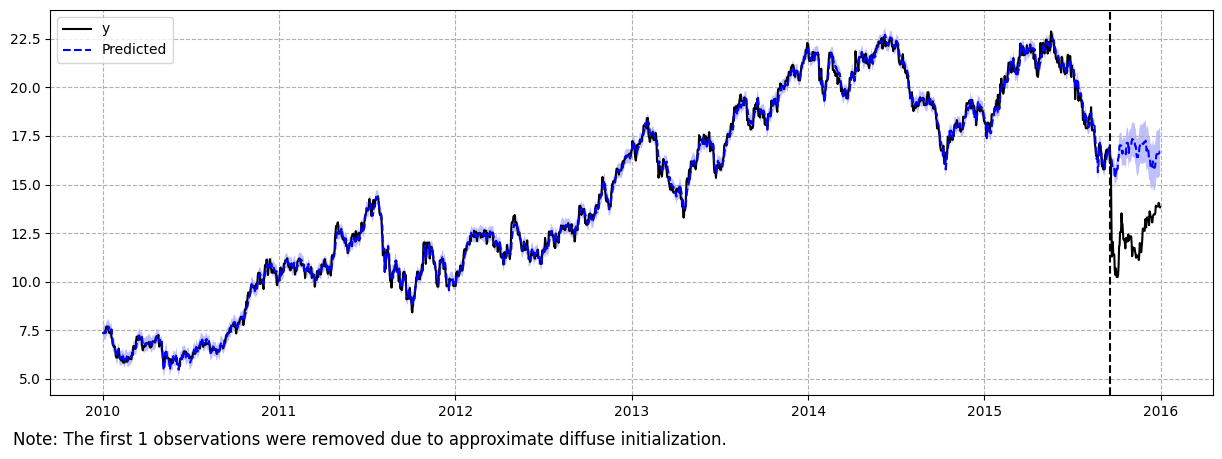

In [25]:
# This graph shows the empirical and counterfactual data
ci.plot(panels=['original'], figsize=(15,5))

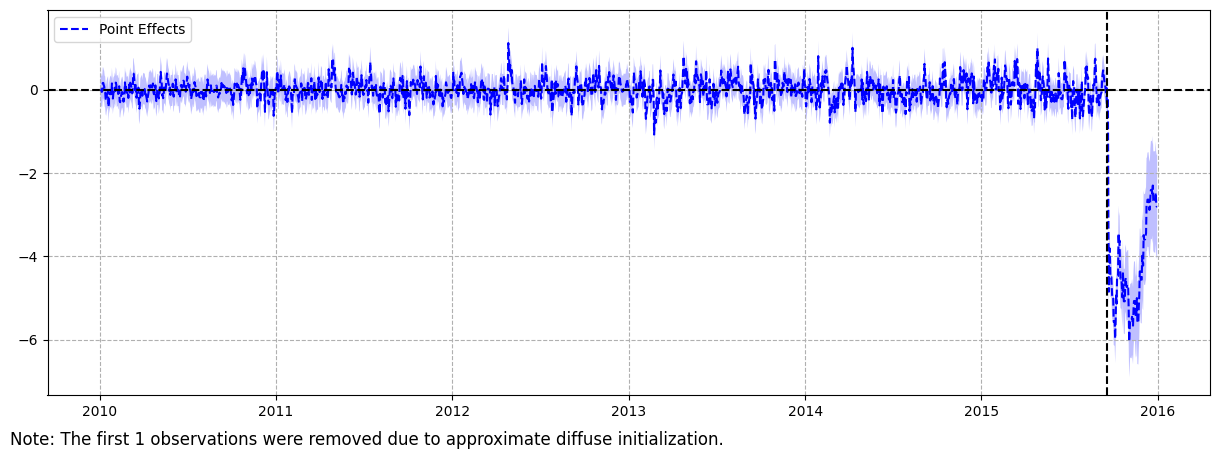

In [26]:
# This graph shows the difference between the empirical and counterfactual data
ci.plot(panels=['pointwise'], figsize=(15,5))

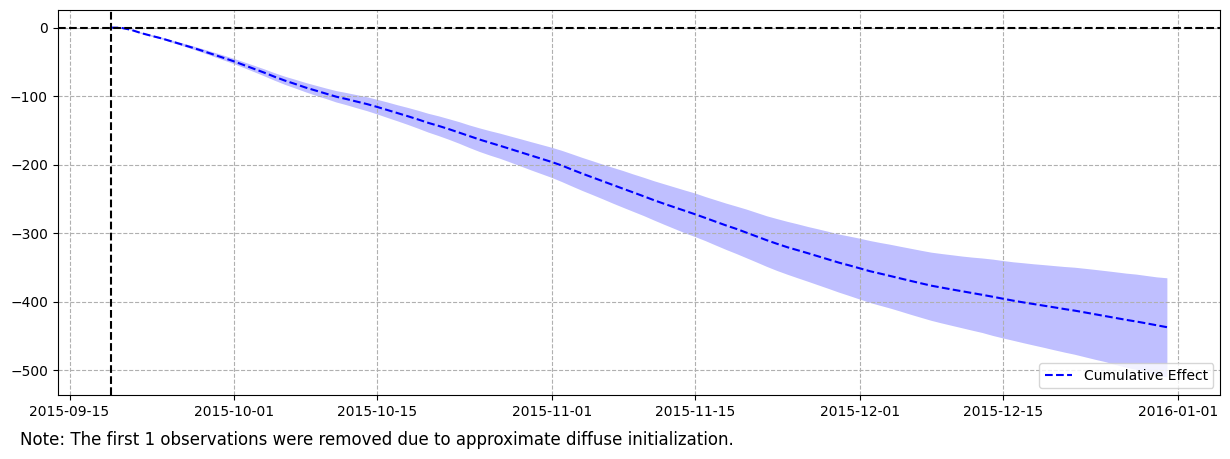

In [27]:
# This graph shows the cumulative difference between the empirical and counterfactual data in the post period
ci.plot(panels=['cumulative'], figsize=(15,5))